# Lesson 4: sMRI Segmentation / Parcellation

## Objectives
- Understand and visualize tissue segmentation
- Manipulate atlases to extract regions of interests
- Visualize and interact with both volumetric and surface data

## Python Requirements
- numpy
- pandas
- [matplotlib](https://matplotlib.org/)
- seaborn
- [nibabel](https://nipy.org/nibabel/)
- pybids
- [nilearn](https://nilearn.github.io/index.html)

## Useful resources:
- FreeSurfer output [description](https://surfer.nmr.mgh.harvard.edu/fswiki/ReconAllTableStableV5.3)

## Dataset used:
- [AOMIC](https://nilab-uva.github.io/AOMIC.github.io/): the Amsterdam Open MRI [Collection](https://openneuro.org/datasets/ds002790/versions/2.0.0)

In [151]:
import os
import numpy as np
import pandas as pd
from nilearn import plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [152]:
%matplotlib inline

In [153]:
nilearn_cache_dir = "../local_data/nilearn_cache"

# Get MRI data

In [154]:
!tree ../local_data/AOMIC

../local_data/AOMIC
├── CHANGES
├── dataset_description.json
├── derivatives
│   ├── fmriprep
│   │   ├── dataset_description.json
│   │   ├── sub-0001
│   │   │   └── anat
│   │   │       ├── sub-0001_desc-aparcaseg_dseg.nii.gz
│   │   │       ├── sub-0001_desc-aseg_dseg.nii.gz
│   │   │       ├── sub-0001_desc-brain_mask.json
│   │   │       ├── sub-0001_desc-brain_mask.nii.gz
│   │   │       ├── sub-0001_desc-preproc_T1w.json
│   │   │       ├── sub-0001_desc-preproc_T1w.nii.gz
│   │   │       ├── sub-0001_dseg.nii.gz
│   │   │       ├── sub-0001_from-MNI152NLin2009cAsym_to-T1w_mode-image_xfm.h5
│   │   │       ├── sub-0001_from-orig_to-T1w_mode-image_xfm.txt
│   │   │       ├── sub-0001_from-T1w_to-fsnative_mode-image_xfm.txt
│   │   │       ├── sub-0001_from-T1w_to-MNI152NLin2009cAsym_mode-image_xfm.h5
│   │   │       ├── sub-0001_hemi-L_inflated.surf.gii
│   │   │       ├── sub-0001_hemi-L_midthickness.surf.gii
│   │   │       ├── sub-0001_hemi-L_pial.surf.gii
│   │   │       ├──

In [162]:
!ls ../local_data/AOMIC/derivatives/fmriprep/sub-0001/anat/*seg*

../local_data/AOMIC/derivatives/fmriprep/sub-0001/anat/sub-0001_desc-aparcaseg_dseg.nii.gz
../local_data/AOMIC/derivatives/fmriprep/sub-0001/anat/sub-0001_desc-aseg_dseg.nii.gz
../local_data/AOMIC/derivatives/fmriprep/sub-0001/anat/sub-0001_dseg.nii.gz
../local_data/AOMIC/derivatives/fmriprep/sub-0001/anat/sub-0001_label-CSF_probseg.nii.gz
../local_data/AOMIC/derivatives/fmriprep/sub-0001/anat/sub-0001_label-GM_probseg.nii.gz
../local_data/AOMIC/derivatives/fmriprep/sub-0001/anat/sub-0001_label-GM_probseg_to_GM226_2mm.log
../local_data/AOMIC/derivatives/fmriprep/sub-0001/anat/sub-0001_label-WM_probseg.nii.gz
../local_data/AOMIC/derivatives/fmriprep/sub-0001/anat/sub-0001_space-MNI152NLin2009cAsym_dseg.nii.gz
../local_data/AOMIC/derivatives/fmriprep/sub-0001/anat/sub-0001_space-MNI152NLin2009cAsym_label-CSF_probseg.nii.gz
../local_data/AOMIC/derivatives/fmriprep/sub-0001/anat/sub-0001_space-MNI152NLin2009cAsym_label-GM_probseg.nii.gz
../local_data/AOMIC/derivatives/fmriprep/sub-0001/ana

## Read BIDS data with `pybids` package

In [5]:
from bids import BIDSLayout

In [163]:
data_dir = '../local_data/AOMIC'
bids_layout = BIDSLayout(data_dir, derivatives=True)
bids_layout

BIDS Layout: ...SDC-BIDS-sMRI/local_data/AOMIC | Subjects: 2 | Sessions: 0 | Runs: 0

## Brain tissue segmentation

### In normal controls

#### Load relevant data with `nibabel` 

In [10]:
import nibabel as nib

##### T1 data

In [11]:
# Identify the right file with pybids
t1_file = bids_layout.get(subject="0001", scope="derivatives", datatype='anat', desc='preproc',
                          extension='nii.gz', return_type='filename')[0]
# Load it with nibabel
t1 = nib.load(t1_file)
t1_data = t1.get_fdata()
t1_affine = t1.affine

##### Binary brain mask data

In [12]:
# Identify the right file with pybids
t1_mask_file = bids_layout.get(subject="0001", scope="derivatives", datatype='anat', suffix='mask',
                               desc='brain', extension='nii.gz', return_type='filename')[0]
# Load it with nibabel
t1_mask = nib.load(t1_mask_file)
t1_mask_data = t1_mask.get_fdata()

##### Apply brain mask on T1 data to get only brain data

In [13]:
t1_brain_data = np.where(t1_mask_data.astype('bool'), t1_data, 0)

##### Visualize volumetric data and intensity histogram

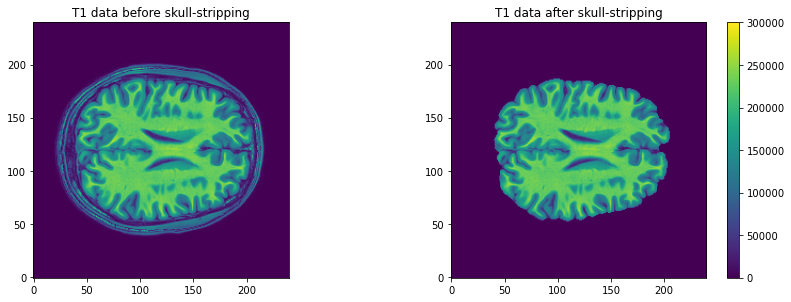

In [225]:
plt.figure(figsize=(12, 8))
n_plots = 2
n_cols = 2
# Plot first figure
plt.subplot(n_plots, n_cols, 1)
plt.imshow(t1_data[:, :, 110], vmax=300000, origin="lower")
plt.title('T1 data before skull-stripping')
# Plot first figure
plt.subplot(n_plots, n_cols, 2)
plt.imshow(t1_brain_data[:, :, 110], vmax=300000, origin="lower")
plt.title('T1 data after skull-stripping')
plt.colorbar();
plt.tight_layout() # Magic command to optimize the multiple plots layout

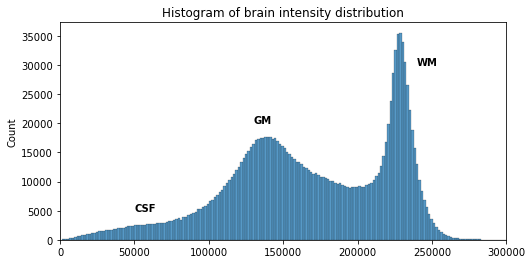

In [190]:
plt.figure(figsize=(8, 4))
# Compute the optimal bin size according to the data
bins = np.histogram_bin_edges(t1_brain_data[t1_brain_data != 0], bins='auto')
# Plot the histogram
sns.histplot(t1_brain_data[t1_brain_data != 0], bins=bins)
plt.xlim([0, 300000])
plt.title('Histogram of brain intensity distribution')
plt.text(50000, 5000, "CSF", size='medium', weight='bold')
plt.text(130000, 20000, "GM", size='medium', weight='bold')
plt.text(240000, 30000, "WM", size='medium', weight='bold');

##### Challenge: can you modify the code above to plot the intensity distribution before skull-stripping ? 

#### Visualize individual tissue classes and associated histograms

In [18]:
from nilearn import plotting

##### Segmentation data

In [198]:
# Identify the right file with pybids
t1_seg_file = bids_layout.get(subject="0001", scope="derivatives", datatype='anat', suffix='dseg',
                              extension='nii.gz', return_type='filename')[2]
# Load it with nibabel
t1_seg = nib.load(t1_seg_file)
t1_seg_data = t1_seg.get_fdata()

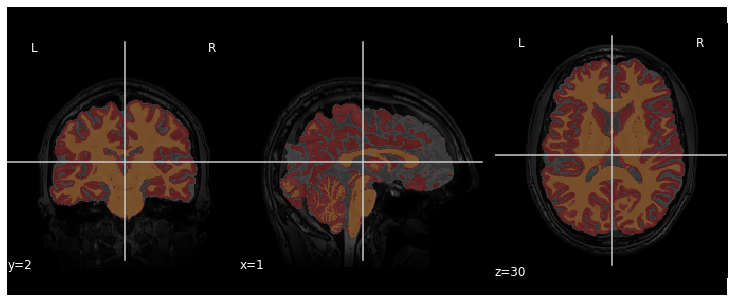

In [201]:
fig = plt.figure(figsize=(10, 4))
plotting.plot_roi(roi_img=t1_seg, bg_img=t1, alpha=0.3, cmap="Set1", figure=fig);

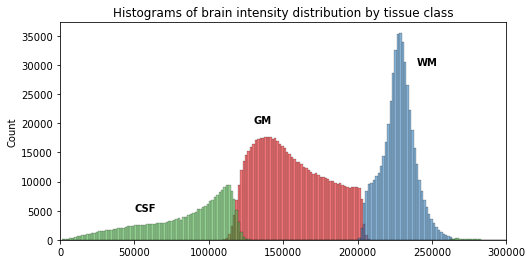

In [200]:
import itertools
labels = np.unique(t1_seg_data[t1_seg_data != 0]).astype('int')
plt.figure(figsize=(8, 4))
palette = itertools.cycle(sns.color_palette("Set1"))
for label in labels:
    sns.histplot(t1_brain_data[t1_seg_data == label], bins=bins, color=next(palette), alpha=0.6)
plt.xlim([0, 300000])
plt.title('Histograms of brain intensity distribution by tissue class')
plt.text(50000, 5000, "CSF", size='medium', weight='bold')
plt.text(130000, 20000, "GM", size='medium', weight='bold')
plt.text(240000, 30000, "WM", size='medium', weight='bold');

##### Probability map

In [218]:
# Identify the right file with pybids
GM_probmap_file = bids_layout.get(subject="0001", scope="derivatives", datatype='anat', 
                                  label="GM", suffix="probseg", 
                                  extension='nii.gz', return_type='filename')[0]
# Load it with nibabel
GM_probmap = nib.load(GM_probmap_file)

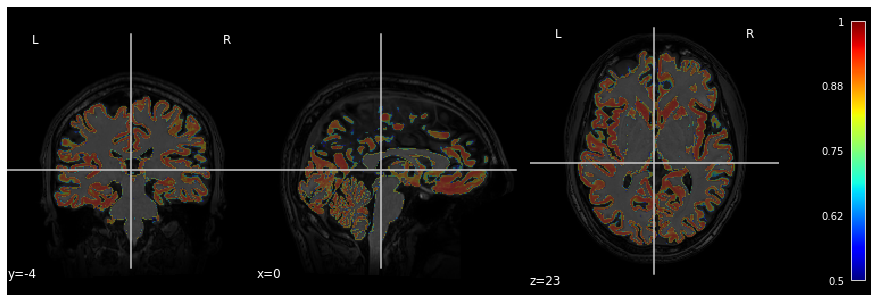

In [251]:
fig = plt.figure(figsize=(12, 4))
plotting.plot_roi(roi_img=GM_probmap, bg_img=t1, alpha=0.3, figure=fig, colorbar=True,
                  cmap="jet", vmin=0.5, vmax=1);

#### Visualize surface data

##### GII format

In [269]:
# What kind of GII surface files do we have for the left hemisphere ?
bids_layout.get(subject="0001", scope="derivatives", datatype='anat', hemi="L",  
                extension='surf.gii', return_type='filename')

['/mnt/linux_data/projects/teaching/carpentry/smri/SDC-BIDS-sMRI/local_data/AOMIC/derivatives/fmriprep/sub-0001/anat/sub-0001_hemi-L_inflated.surf.gii',
 '/mnt/linux_data/projects/teaching/carpentry/smri/SDC-BIDS-sMRI/local_data/AOMIC/derivatives/fmriprep/sub-0001/anat/sub-0001_hemi-L_midthickness.surf.gii',
 '/mnt/linux_data/projects/teaching/carpentry/smri/SDC-BIDS-sMRI/local_data/AOMIC/derivatives/fmriprep/sub-0001/anat/sub-0001_hemi-L_pial.surf.gii',
 '/mnt/linux_data/projects/teaching/carpentry/smri/SDC-BIDS-sMRI/local_data/AOMIC/derivatives/fmriprep/sub-0001/anat/sub-0001_hemi-L_smoothwm.surf.gii']

In [38]:
pial_surf_file = bids_layout.get(subject="0001", scope="derivatives", datatype='anat', hemi='L',
                            extension='surf.gii', return_type='filename')[0]

Now extract the mesh components to feed them to the `plot_surf` function of `nilearn`.

In [270]:
pial_surf = nib.load(pial_surf_file)
pial_verts, pial_faces = pial_surf.agg_data(('pointset', 'triangle'))

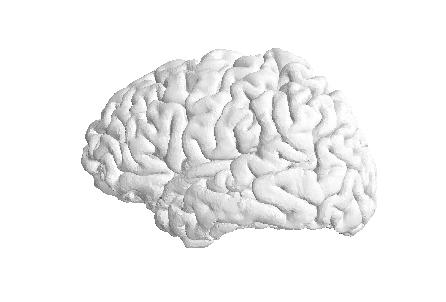

In [271]:
plotting.plot_surf((pial_verts, pial_faces));

##### Native Freesurfer format

This is more straightforward

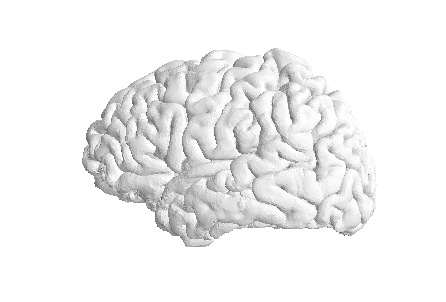

In [273]:
fs_surf_dir = "../local_data/AOMIC/derivatives/freesurfer/sub-0001/surf"
fs_pial_surf = os.path.join(fs_surf_dir, "lh.pial")
plotting.plot_surf(fs_pial_surf);

In [274]:
#plotting.view_surf(fs_pial_surf, black_bg=True)

##### Challenge: can you modify the code above to plot the white matter surface ? 

## Segmenting tissue classes into sub-components: atlasing, parcellation

In [277]:
atlas_dir = os.path.join(nilearn_cache_dir, 'atlases')

### Visualizing and extracting ROIs of a non probabilistic volumetric atlas: AAL

In [275]:
from nilearn.datasets import fetch_atlas_aal

In [276]:
AAL_dataset = fetch_atlas_aal(data_dir=atlas_dir)
AAL_maps = AAL_dataset.maps
AAL_labels = AAL_dataset['labels']
AAL_labels_ix = AAL_dataset['indices']

##### Check atlas dimension

In [61]:
AAL_img = nib.load(AAL_maps)

In [62]:
AAL_img.shape

(91, 109, 91)

#### Plot the atlas on the subject T1 registered to the atlas template

In [56]:
t1_mni_file = bids_layout.get(subject="0001", scope="derivatives", 
                              datatype='anat', desc='preproc',
                              space='MNI152NLin2009cAsym', 
                              extension='nii.gz', 
                              return_type='filename')[0]

In [57]:
t1_mni = nib.load(t1_mni_file)

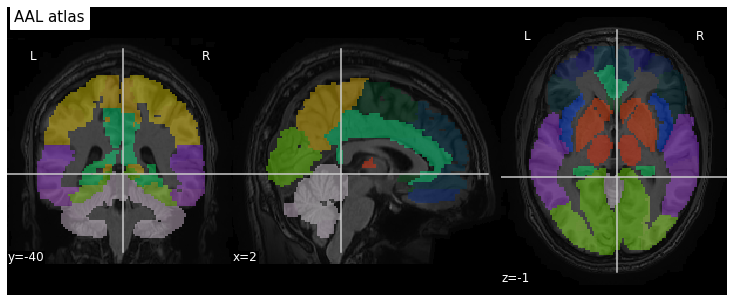

In [100]:
fig = plt.figure(figsize=(10, 4))
plotting.plot_roi(roi_img=AAL_maps, bg_img=t1_mni, alpha=0.4, title="AAL atlas", figure=fig);

#### Identifying an ROI integer index

In [278]:
AAL_labels

['Precentral_L',
 'Precentral_R',
 'Frontal_Sup_L',
 'Frontal_Sup_R',
 'Frontal_Sup_Orb_L',
 'Frontal_Sup_Orb_R',
 'Frontal_Mid_L',
 'Frontal_Mid_R',
 'Frontal_Mid_Orb_L',
 'Frontal_Mid_Orb_R',
 'Frontal_Inf_Oper_L',
 'Frontal_Inf_Oper_R',
 'Frontal_Inf_Tri_L',
 'Frontal_Inf_Tri_R',
 'Frontal_Inf_Orb_L',
 'Frontal_Inf_Orb_R',
 'Rolandic_Oper_L',
 'Rolandic_Oper_R',
 'Supp_Motor_Area_L',
 'Supp_Motor_Area_R',
 'Olfactory_L',
 'Olfactory_R',
 'Frontal_Sup_Medial_L',
 'Frontal_Sup_Medial_R',
 'Frontal_Med_Orb_L',
 'Frontal_Med_Orb_R',
 'Rectus_L',
 'Rectus_R',
 'Insula_L',
 'Insula_R',
 'Cingulum_Ant_L',
 'Cingulum_Ant_R',
 'Cingulum_Mid_L',
 'Cingulum_Mid_R',
 'Cingulum_Post_L',
 'Cingulum_Post_R',
 'Hippocampus_L',
 'Hippocampus_R',
 'ParaHippocampal_L',
 'ParaHippocampal_R',
 'Amygdala_L',
 'Amygdala_R',
 'Calcarine_L',
 'Calcarine_R',
 'Cuneus_L',
 'Cuneus_R',
 'Lingual_L',
 'Lingual_R',
 'Occipital_Sup_L',
 'Occipital_Sup_R',
 'Occipital_Mid_L',
 'Occipital_Mid_R',
 'Occipital_Inf_L'

In [279]:
roi_label = "Supp_Motor_Area_L"
roi_label_pos = AAL_labels.index(roi_label)
roi_ix = int(AAL_labels_ix[roi_label_pos])
roi_ix

2401

#### Getting all voxels corresponding to that index

In [281]:
roi_mask_arr_bool = (AAL_img.get_fdata() == roi_ix)
roi_mask_arr = roi_mask_arr_bool.astype(np.int32)

In [282]:
roi_mask = nib.Nifti1Image(roi_mask_arr, affine=AAL_img.affine)

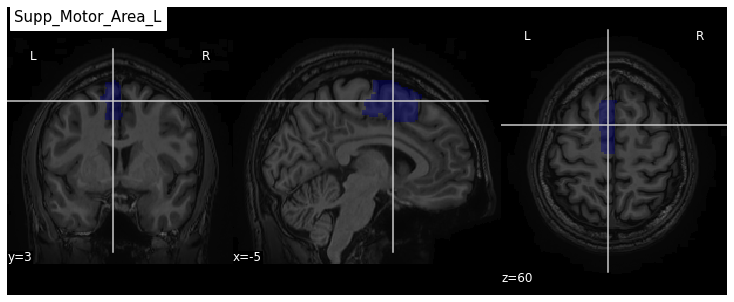

In [283]:
fig = plt.figure(figsize=(10, 4))
plotting.plot_roi(roi_img=roi_mask, bg_img=t1_mni, alpha=0.4, title=roi_label, figure=fig);

### Visualizing and extracting ROIs of a surface atlas

In [129]:
from nilearn.datasets import fetch_atlas_surf_destrieux
from nilearn.datasets import fetch_surf_fsaverage

In [130]:
# Destrieux parcellation for left hemisphere in fsaverage5 space
destrieux = fetch_atlas_surf_destrieux()
parcellation_L = destrieux['map_left']
parcellation_R = destrieux['map_right']
destrieux_labels = destrieux['labels']

In [131]:
destrieux_labels

[b'Unknown',
 b'G_and_S_frontomargin',
 b'G_and_S_occipital_inf',
 b'G_and_S_paracentral',
 b'G_and_S_subcentral',
 b'G_and_S_transv_frontopol',
 b'G_and_S_cingul-Ant',
 b'G_and_S_cingul-Mid-Ant',
 b'G_and_S_cingul-Mid-Post',
 b'G_cingul-Post-dorsal',
 b'G_cingul-Post-ventral',
 b'G_cuneus',
 b'G_front_inf-Opercular',
 b'G_front_inf-Orbital',
 b'G_front_inf-Triangul',
 b'G_front_middle',
 b'G_front_sup',
 b'G_Ins_lg_and_S_cent_ins',
 b'G_insular_short',
 b'G_occipital_middle',
 b'G_occipital_sup',
 b'G_oc-temp_lat-fusifor',
 b'G_oc-temp_med-Lingual',
 b'G_oc-temp_med-Parahip',
 b'G_orbital',
 b'G_pariet_inf-Angular',
 b'G_pariet_inf-Supramar',
 b'G_parietal_sup',
 b'G_postcentral',
 b'G_precentral',
 b'G_precuneus',
 b'G_rectus',
 b'G_subcallosal',
 b'G_temp_sup-G_T_transv',
 b'G_temp_sup-Lateral',
 b'G_temp_sup-Plan_polar',
 b'G_temp_sup-Plan_tempo',
 b'G_temporal_inf',
 b'G_temporal_middle',
 b'Lat_Fis-ant-Horizont',
 b'Lat_Fis-ant-Vertical',
 b'Lat_Fis-post',
 b'Medial_wall',
 b'Pol

#### Plotting the atlas

Get the mesh on which to plot the label, which will be the pial mesh of the left hemisphere for us.

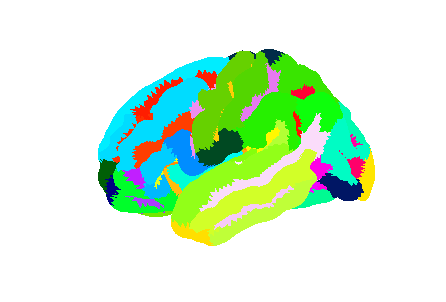

In [285]:
fsaverage = fetch_surf_fsaverage()
mesh = fsaverage['pial_left']
plotting.plot_surf_roi(mesh, roi_map=parcellation_L, hemi='left', view='lateral');

#### Extracting a specific ROI

In [135]:
# Create ROI array
pcc_region = b'G_cingul-Post-dorsal'
roi_ix = destrieux_labels.index(pcc_region)
roi_mask_arr = (parcellation_L == roi_ix).astype(int)

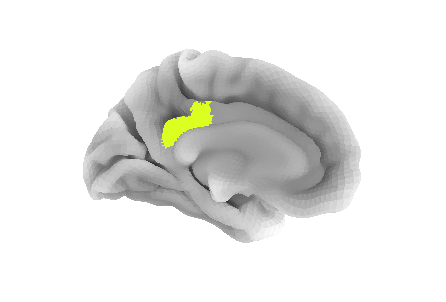

In [136]:
# Plot ROI, 
# using a background image since not all vertices have  label
plotting.plot_surf_roi(mesh, roi_map=roi_mask_arr, hemi='left', view='medial',
                       bg_map=fsaverage['sulc_left']);